# Explore output of best current CNN model (performance & number of parameters) with single image of dataver0

In [1]:
%pip install torch torchvision
%pip install numpy
%pip install matplotlib
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load root project path to sys.path
import sys
import os

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Import the custom utilities
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os
import pickle
from src.models.efficient_net import H0_EfficientNetB0

In [4]:
# dataver0_path = os.path.join(project_root, 'data', 'processed', 'dataver0')
dataver0_path = "/home/haipn/data/dataver0"
train_path = os.path.join(dataver0_path, 'train')
valid_path = os.path.join(dataver0_path, 'valid')
# model_path = os.path.join(project_root, 'results', 'experiment_43', 'experiment_43.pth')
model_path = "/home/haipn/backup/experiment_43/experiment_43.pth"

In [5]:
# 1. Read images from train and valid set
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir, transform=transform)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

# Set up data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = CustomDataset(train_path, transform=transform)
valid_dataset = CustomDataset(valid_path, transform=transform)

# Create data loaders
batch_size = 120
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# 2. Inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = H0_EfficientNetB0().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

def inference(dataloader):
    outputs = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in tqdm(dataloader):
            images = images.to(device)
            batch_outputs = model(images)
            outputs.append(batch_outputs.cpu().numpy())
            labels.append(batch_labels.numpy())
    return np.concatenate(outputs), np.concatenate(labels)

# 3. Get outputs and labels
print("Processing training set...")
train_outputs, train_labels = inference(train_loader)
print("Processing validation set...")
valid_outputs, valid_labels = inference(valid_loader)

/tmp/ipykernel_1414869/1755777352.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Processing training set...


100%|████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.45s/it]


Processing validation set...


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]


In [7]:
# 4. Save to one file
data = {
    'train_outputs': train_outputs,
    'train_labels': train_labels,
    'valid_outputs': valid_outputs,
    'valid_labels': valid_labels
}

with open('cnn_outputs.pkl', 'wb') as f:
    pickle.dump(data, f)

# 5. Visualize x and y of train and valid in 3D
def visualize_3d(outputs, labels, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(outputs[:, 0], outputs[:, 1], outputs[:, 2], c=labels, cmap='viridis')
    ax.set_xlabel('Output 1')
    ax.set_ylabel('Output 2')
    ax.set_zlabel('Output 3')
    ax.set_title(title)
    plt.colorbar(scatter)
    plt.savefig(title + '.png')
    plt.show()

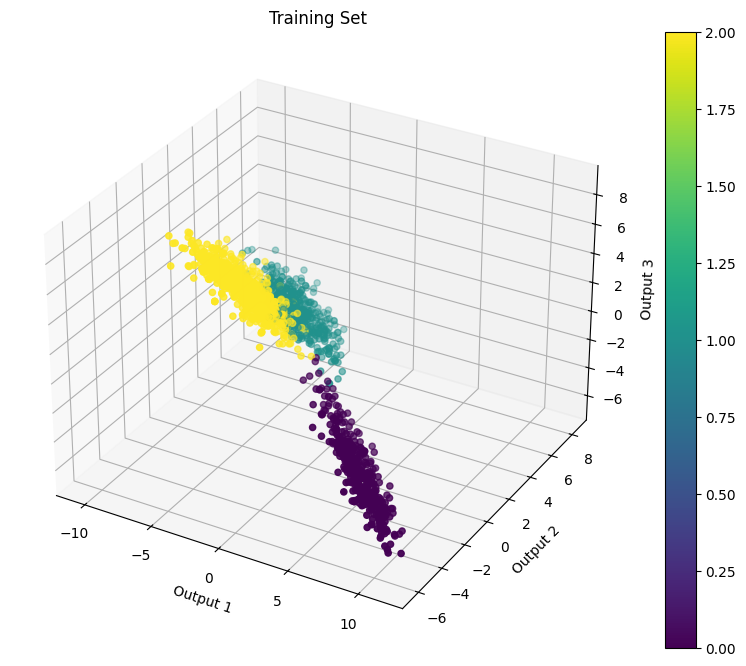

In [8]:
visualize_3d(train_outputs, train_labels, 'Training Set')

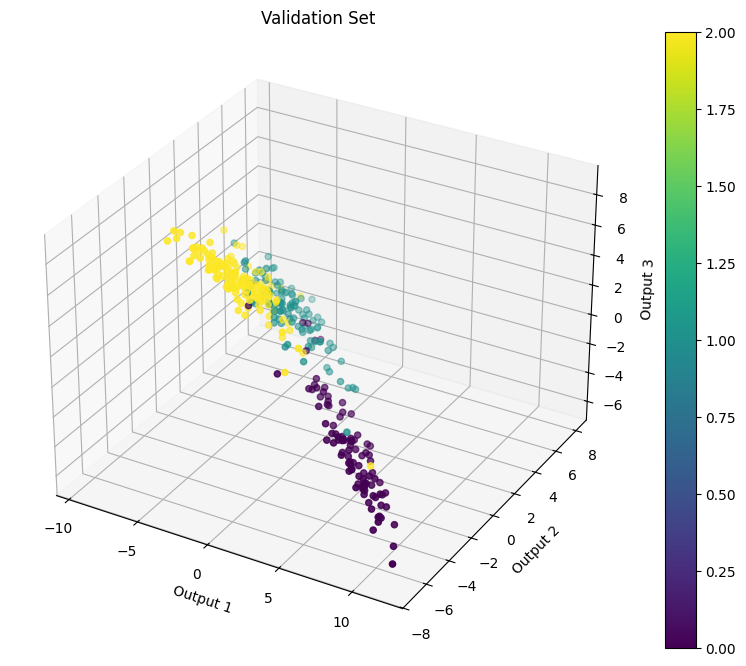

In [9]:
visualize_3d(valid_outputs, valid_labels, 'Validation Set')

In [10]:
# 6. Read the file to load x and y again
with open('cnn_outputs.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

train_outputs = loaded_data['train_outputs']
train_labels = loaded_data['train_labels']
valid_outputs = loaded_data['valid_outputs']
valid_labels = loaded_data['valid_labels']

In [11]:
# 7. Add ReLU function to x and visualize again
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigrelu(x):
    return sigmoid(relu(x))

In [12]:
# Apply ReLU
train_outputs_relu = relu(train_outputs)
valid_outputs_relu = relu(valid_outputs)

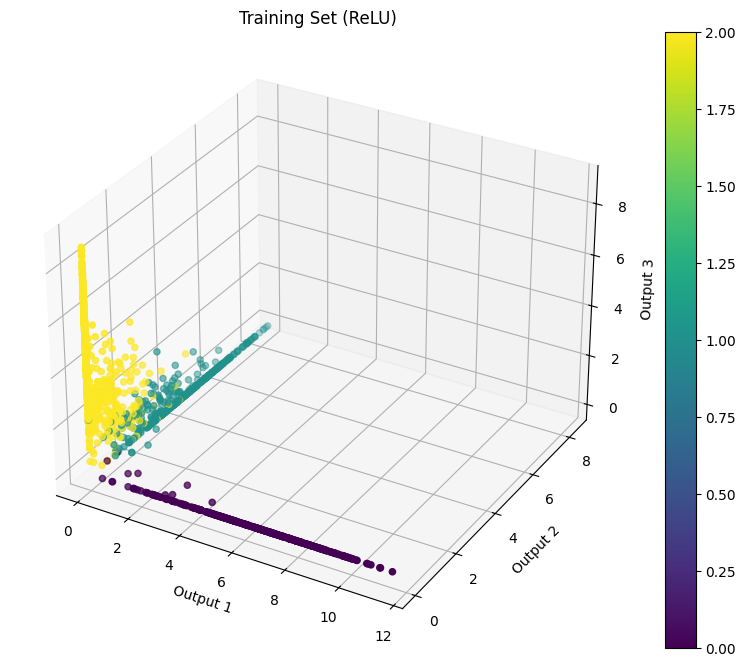

In [13]:
visualize_3d(train_outputs_relu, train_labels, 'Training Set (ReLU)')

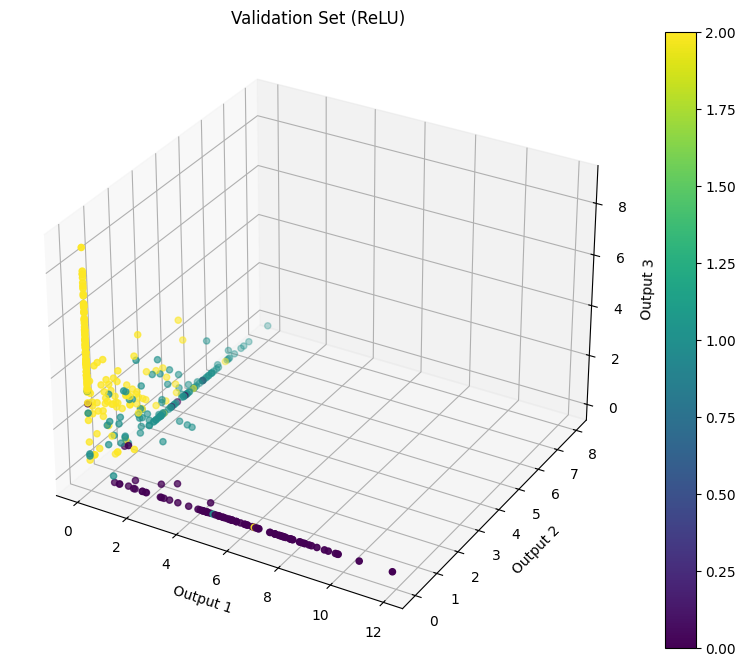

In [14]:
visualize_3d(valid_outputs_relu, valid_labels, 'Validation Set (ReLU)')

In [15]:
# Apply SigReLU
train_outputs_sigrelu = sigrelu(train_outputs)
valid_outputs_sigrelu = sigrelu(valid_outputs)

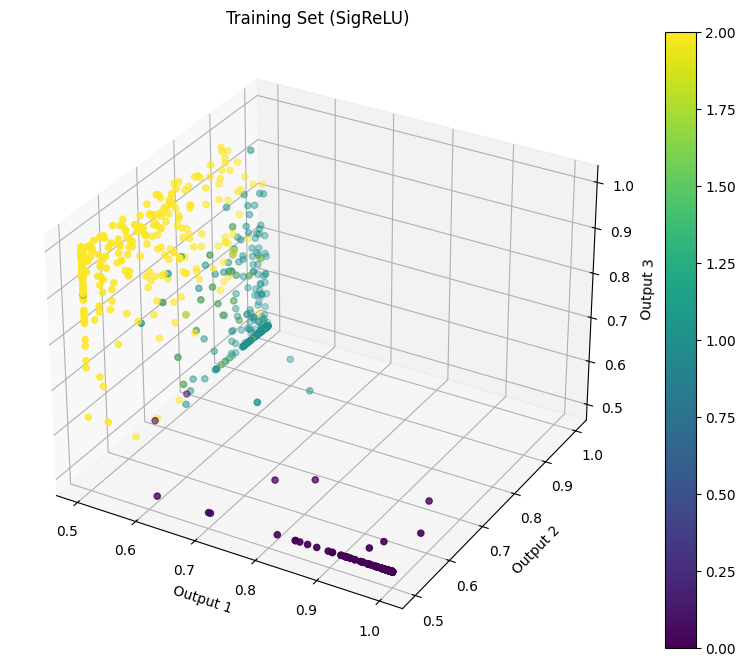

In [16]:
visualize_3d(train_outputs_sigrelu, train_labels, 'Training Set (SigReLU)')

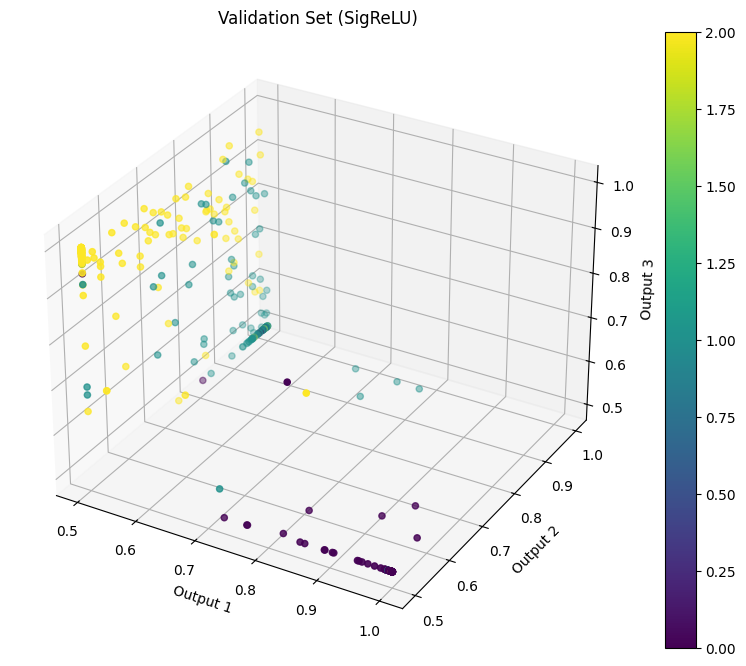

In [17]:
visualize_3d(valid_outputs_sigrelu, valid_labels, 'Validation Set (SigReLU)')

In [18]:
# Apply sigmoid
train_outputs_sigmoid = sigmoid(train_outputs)
valid_outputs_sigmoid = sigmoid(valid_outputs)

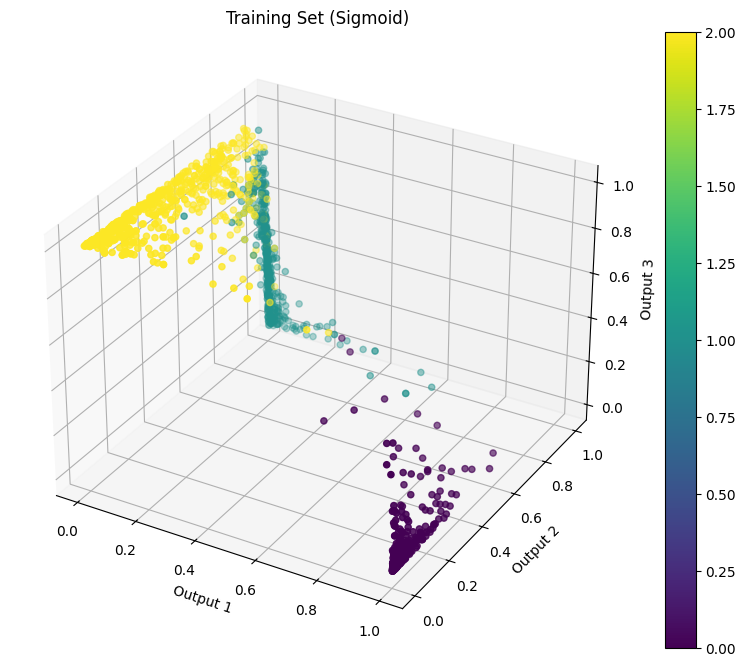

In [19]:
visualize_3d(train_outputs_sigmoid, train_labels, 'Training Set (Sigmoid)')

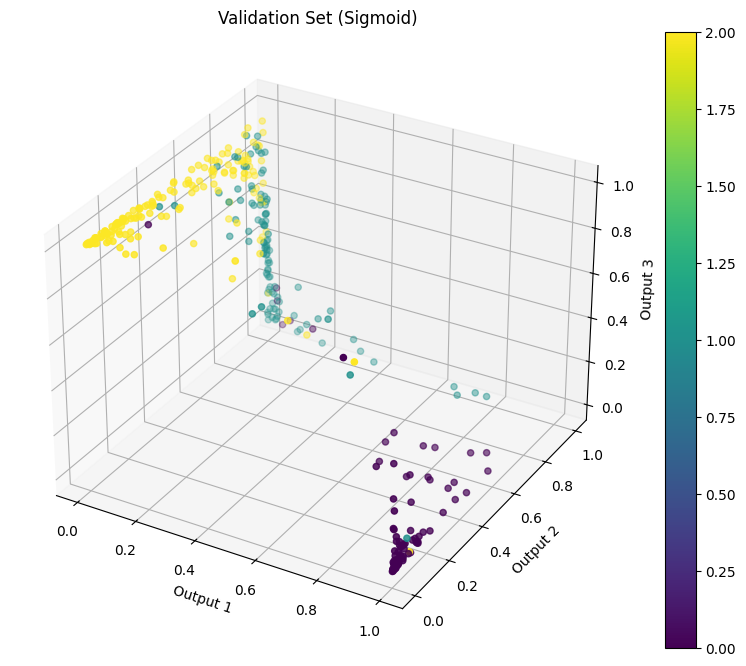

In [20]:
visualize_3d(valid_outputs_sigmoid, valid_labels, 'Validation Set (Sigmoid)')

# Explore output of best current CNN model (with single image of dataver0 + 12 patch image from dataver0)

In [ ]:
# Load root project path to sys.path
import sys
import os

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
# Import the custom utilities
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os
import pickle
from src.models.efficient_net import H0_EfficientNetB0

In [ ]:
# dataver0_path = os.path.join(project_root, 'data', 'processed', 'dataver0')
dataver0_path = "/home/haipn/data/dataver0"
train_path = os.path.join(dataver0_path, 'train')
valid_path = os.path.join(dataver0_path, 'valid')
# model_path = os.path.join(project_root, 'results', 'experiment_43', 'experiment_43.pth')
model_path = "/home/haipn/backup/experiment_43/experiment_43.pth"

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels = self._get_image_paths_and_labels()

    def _get_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for label_folder in os.listdir(self.root_dir):
            label_folder_path = os.path.join(self.root_dir, label_folder)
            if os.path.isdir(label_folder_path):
                for img_file in os.listdir(label_folder_path):
                    image_paths.append(os.path.join(label_folder_path, img_file))
                    labels.append(label_folder)
        return image_paths, labels

    def _crop_image(self, img):
        img_crops = []
        width, height = img.size
        crop_width = 256
        crop_height = 256
        for i in range(3):  # 3 rows
            for j in range(4):  # 4 columns
                left = j * crop_width
                top = i * crop_height
                right = min(left + crop_width, width)
                bottom = min(top + crop_height, height)
                crop = img.crop((left, top, right, bottom))
                img_crops.append(crop)
        return img_crops

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]  # Get the label for the original image

        img = Image.open(img_path).convert("RGB")

        # Resize to 1024x768
        img_resized = img.resize((1024, 768))

        # Crop the image into 12 pieces
        crops = self._crop_image(img_resized)

        # Resize crops to 224x224
        crops_resized = [crop.resize((224, 224)) for crop in crops]

        # Transform crops to tensors
        crops_tensor = [transforms.ToTensor()(crop) for crop in crops_resized]

        # Create the original image tensor
        if self.transform:
            img_resized = self.transform(img_resized)

        # Stack the original image and cropped images
        all_tensors = [img_resized] + crops_tensor

        # Convert label to tensor
        label_tensor = torch.tensor(self._get_label_index(label))  # make one-hot label

        return torch.stack(all_tensors), label_tensor

    def _get_label_index(self, label):
        # Convert label to an index (you may need to update this method based on how you encode labels)
        # Example: mapping label to integer index
        unique_labels = sorted(set(self.labels))
        return unique_labels.index(label)


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

train_dataset = CustomDataset(root_dir=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

valid_dataset = CustomDataset(root_dir=valid_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
dataset = train_dataset
image, cropped_images, label = dataset[0]

# Xem ảnh gốc và các miếng cắt
image.show()
for i, crop in enumerate(cropped_images):
    crop.show(title=f'Crop {i}')

In [ ]:
# 2. Inference
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = H0_EfficientNetB0().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

def inference(dataloader):
    outputs = []
    labels = []
    with torch.no_grad():
        for images, batch_label in tqdm(dataloader):
            images = images.to(device)
            batch_outputs = model(images)
            outputs.append(batch_outputs.cpu().numpy())
            labels.append(batch_label.numpy())
    return np.concatenate(outputs), np.concatenate(labels)

# Perform inference
print("Processing training set...")
train_outputs, train_labels = inference(train_loader)
print("Processing validation set...")
valid_outputs, valid_labels = inference(valid_loader)

# Convert outputs and labels to DataFrame
train_df = pd.DataFrame(train_outputs)
train_df['label'] = train_labels

valid_df = pd.DataFrame(valid_outputs)
valid_df['label'] = valid_labels

# Save DataFrames to CSV
train_df.to_csv('train_outputs_labels.csv', index=False)
valid_df.to_csv('valid_outputs_labels.csv', index=False)

print("Results saved to CSV files.")

In [ ]:
import pandas as pd

# Đọc dữ liệu từ CSV
train_df = pd.read_csv('train_outputs_labels.csv')
valid_df = pd.read_csv('valid_outputs_labels.csv')

# Xem cấu trúc của DataFrame
print(train_df.head())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hàm để trực quan hóa phân phối đầu ra
def plot_output_distribution(df, output_cols, label_col):
    # Đọc nhãn và đầu ra
    labels = df[label_col].values
    outputs = df[output_cols].values
    
    # Tạo một DataFrame với các giá trị đầu ra và nhãn
    output_df = pd.DataFrame(outputs, columns=[f'output_{i}' for i in range(outputs.shape[1])])
    output_df[label_col] = labels
    
    # Vẽ phân phối cho từng lớp đầu ra
    plt.figure(figsize=(15, 10))
    for i in range(outputs.shape[1]):
        plt.subplot(outputs.shape[1] // 3 + 1, 3, i + 1)
        sns.histplot(output_df[f'output_{i}'], bins=30, kde=True, hue=output_df[label_col])
        plt.title(f'Distribution of Output {i}')
        plt.xlabel('Output Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Ví dụ sử dụng
output_cols = [f'output_{i}' for i in range(39)]  # Điều chỉnh nếu số lượng đầu ra khác
plot_output_distribution(train_df, output_cols, 'label')
